<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/portfolio/1_pc_portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import sklearn.decomposition
from sklearn.decomposition import PCA
import seaborn as sns

def get_nifty50_tickers():
    #data = pd.read_csv('https://raw.githubusercontent.com/anirbanghoshsbi/data/main/STOCKS100.txt', sep='\t')
    data=pd.read_csv('https://raw.githubusercontent.com/anirbanghoshsbi/data/main/ind_nifty100list.csv')
    nifty100 = data['Symbol'].apply(lambda x: x + ".NS").tolist()
    reject_lst=['MOTHERSUMI.NS', 'CADILAHC.NS', 'ADANITRANS.NS', 'SRTRANSFIN.NS', 'INFRATEL-EQ.NS','HDFC.NS','LTI.NS']
    nifty_final= [item for item in nifty100 if item not in reject_lst]
    return nifty_final # Function to retrieve Nifty 50 stock data def get_nifty_50_data(): nifty_50_symbols=get_nifty50_tickers() start_date = "2023-02-01" end_date = "2024-01-30" nifty_50_data = yf.download(nifty_50_symbols, start=start_date, end=end_date)["Adj Close"]

def get_nifty_50_data():
    nifty_50_symbols=get_nifty50_tickers()
    start_date = "2020-02-01"
    end_date = "2024-01-30"
    nifty_50_data = yf.download(nifty_50_symbols, start=start_date, end=end_date)["Adj Close"]
    return nifty_50_data,nifty_50_symbols
asset_prices,nifty100=get_nifty_50_data()
# Asset Returns Calculation (Part 1)
asset_returns = asset_prices.pct_change().dropna()
normed_returns = (asset_returns - asset_returns.mean()) / asset_returns.std()

# Print last 5 rows and last 10 columns of normalized returns DataFrame
print(normed_returns.iloc[-5:, -10:].head())

# Train/Test Split
train_end = datetime.datetime(2023, 2, 28)

df_train = normed_returns[normed_returns.index <= train_end].copy()
df_test = normed_returns[normed_returns.index > train_end].copy()

df_raw_train = asset_returns[asset_returns.index <= train_end].copy()
df_raw_test = asset_returns[asset_returns.index > train_end].copy()

print('Train dataset:', df_train.shape)
print('Test dataset:', df_test.shape)


[*********************100%%**********************]  96 of 96 completed


Ticker      TATASTEEL.NS    TCS.NS  TECHM.NS  TITAN.NS  TORNTPHARM.NS  \
Date                                                                    
2024-01-22     -0.070427 -0.046869 -0.050158 -0.091489      -0.062777   
2024-01-23     -1.463815 -1.676598 -0.984791 -1.258153       0.716571   
2024-01-24      1.679227 -0.369961  1.638313  0.381017       0.294874   
2024-01-25     -0.537354 -0.668206 -3.459002 -0.052411      -0.936447   
2024-01-29      0.350838 -0.231829 -0.375581  1.511473      -0.997015   

Ticker      ULTRACEMCO.NS    UPL.NS   VEDL.NS  WIPRO.NS  YESBANK.NS  
Date                                                                 
2024-01-22      -0.070896 -0.029140 -0.085835 -0.033840   -0.037837  
2024-01-23      -1.769975 -1.792042 -2.217477 -1.965775   -1.722549  
2024-01-24       0.988276  1.031897  1.552368  1.173160    1.003210  
2024-01-25      -0.209105 -0.854567  0.073012 -1.075411    0.196082  
2024-01-29       1.924410  0.204030  0.547007  0.360972   -0.812860 

15 components explain 80.00% of variance
Sum of weights of first eigen-portfolio: 100.00
First eigen-portfolio:
Return = -28.79%
Volatility = 27.37%
Sharpe = -1.05


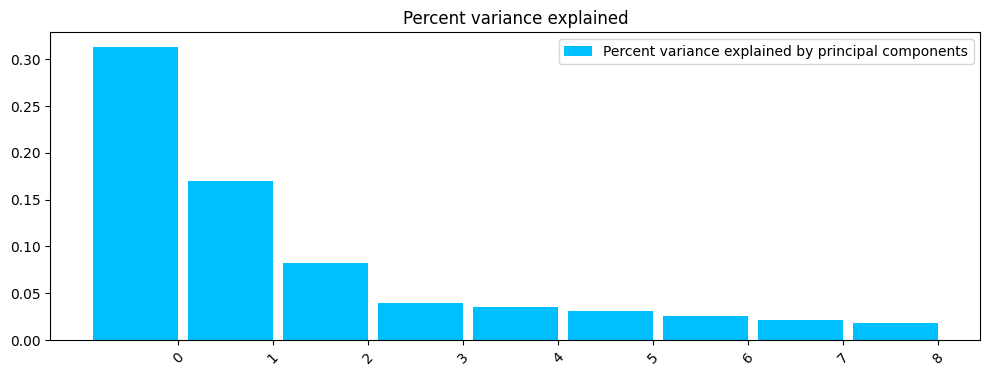

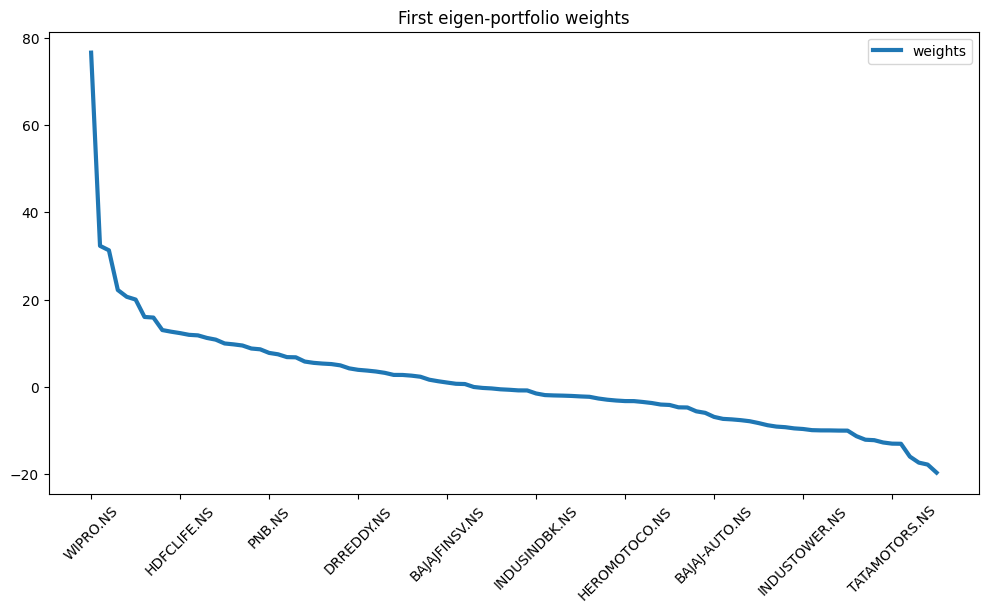

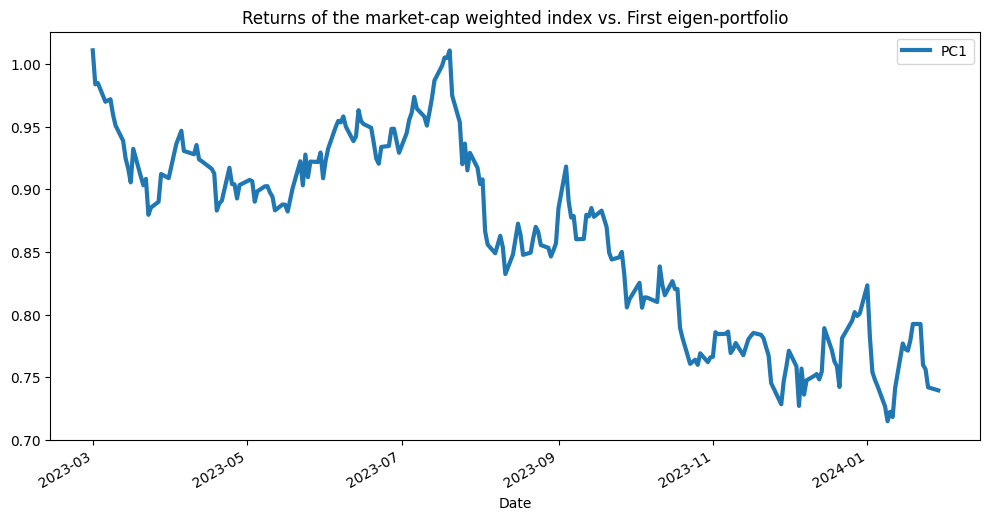

In [ ]:

# PCA fitting
if df_train is not None and df_raw_train is not None:
    cov_matrix = df_train.loc[:, df_train.columns].cov()
    pca = PCA().fit(cov_matrix)
    cov_matrix_raw = df_raw_train.loc[:, df_raw_train.columns].cov()
    cov_raw_df = pd.DataFrame({'Variance': np.diag(cov_matrix_raw)}, index=nifty100)
    var_threshold = 0.8
    var_explained = np.cumsum(pca.explained_variance_ratio_)
    num_comp = np.where(np.logical_not(var_explained < var_threshold))[0][0] + 1
    print('%d components explain %.2f%% of variance' % (num_comp, 100 * var_threshold))

# Bar plot visualization
if pca is not None:
    bar_width = 0.9
    n_asset = int((1 / 10) * normed_returns.shape[1])
    x_indx = np.arange(n_asset)
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    rects = ax.bar(x_indx, pca.explained_variance_ratio_[:n_asset], bar_width, color='deepskyblue')
    ax.set_xticks(x_indx + bar_width / 2)
    ax.set_xticklabels(list(range(n_asset)), rotation=45)
    ax.set_title('Percent variance explained')
    ax.legend((rects[0],), ('Percent variance explained by principal components',))

# Eigen-portfolio construction (Part 3)
pc_w = np.zeros(len(nifty100))
eigen_prtf1 = pd.DataFrame(data={'weights': pc_w.squeeze() * 100}, index=nifty100)

if pca is not None:
    pcs = pca.components_
    pc_w = pcs[:, 0] / sum(pcs[:, 0])
    eigen_prtf1 = pd.DataFrame(data={'weights': pc_w.squeeze() * 100}, index=nifty100)
    eigen_prtf1.sort_values(by=['weights'], ascending=False, inplace=True)
    print('Sum of weights of first eigen-portfolio: %.2f' % np.sum(eigen_prtf1))
    eigen_prtf1.plot(title='First eigen-portfolio weights',
                     figsize=(12, 6),
                     xticks=range(0, len(nifty100), 10),
                     rot=45,
                     linewidth=3)

# Performance Calculation (Part 4)
def sharpe_ratio(ts_returns, periods_per_year=252):
    annualized_return = 0.
    annualized_vol = 0.
    annualized_sharpe = 0.

    n_years = ts_returns.shape[0] / periods_per_year
    annualized_return = np.power(np.prod(1 + ts_returns), (1 / n_years)) - 1
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol

    return annualized_return, annualized_vol, annualized_sharpe

if df_raw_test is not None:
    eigen_prtf1_returns = np.dot(df_raw_test.loc[:, eigen_prtf1.index], eigen_prtf1 / 100)
    eigen_prtf1_returns = pd.Series(eigen_prtf1_returns.squeeze(), index=df_test.index)
    er, vol, sharpe = sharpe_ratio(eigen_prtf1_returns)
    print('First eigen-portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (er*100, vol*100, sharpe))
    year_frac = (eigen_prtf1_returns.index[-1] - eigen_prtf1_returns.index[0]).days / 252

    df_plot = pd.DataFrame({'PC1': eigen_prtf1_returns}, index=df_test.index)
    np.cumprod(df_plot + 1).plot(title='Returns of the market-cap weighted index vs. First eigen-portfolio',
                                 figsize=(12, 6), linewidth=3)



Sum of weights of second eigen-portfolio: 100.00
Second eigen-portfolio:
Return = 52.29%
Volatility = 55.91%
Sharpe = 0.94


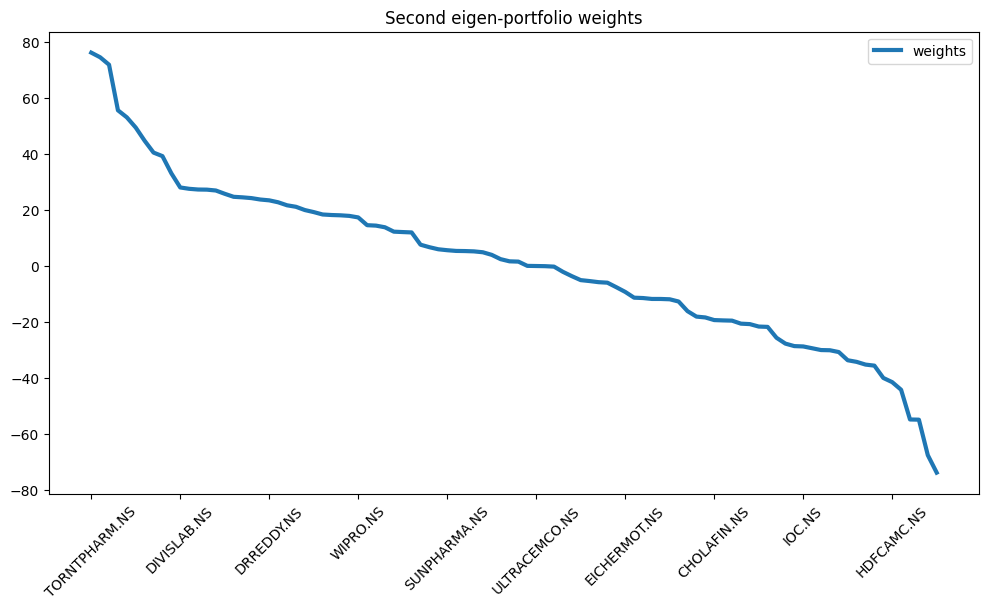

In [ ]:
# Repeat for second eigen-portfolio
pc_w = np.zeros(len(nifty100))
eigen_prtf2 = pd.DataFrame(data={'weights': pc_w.squeeze() * 100}, index=nifty100)

if pca is not None:
    pcs = pca.components_
    pc_w = pcs[:, 1] / sum(pcs[:, 1])
    eigen_prtf2 = pd.DataFrame(data={'weights': pc_w.squeeze() * 100}, index=nifty100)
    eigen_prtf2.sort_values(by=['weights'], ascending=False, inplace=True)
    print('Sum of weights of second eigen-portfolio: %.2f' % np.sum(eigen_prtf2))
    eigen_prtf2.plot(title='Second eigen-portfolio weights',
                     figsize=(12, 6),
                     xticks=range(0, len(nifty100), 10),
                     rot=45,
                     linewidth=3)

if df_raw_test is not None:
    eigen_prtf2_returns = np.dot(df_raw_test.loc[:, eigen_prtf2.index], eigen_prtf2 / 100)
    eigen_prtf2_returns = pd.Series(eigen_prtf2_returns.squeeze(), index=df_test.index)
    er, vol, sharpe = sharpe_ratio(eigen_prtf2_returns)
    print('Second eigen-portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (er*100, vol*100, sharpe))


This code snippet is a Python script that demonstrates how to perform Eigen-portfolio construction using Principal Component Analysis (PCA) on S&P 500 index stock data. The code is divided into several parts:

1. Importing necessary libraries: The code imports libraries such as NumPy, pandas, and matplotlib for data manipulation and visualization.

2. Loading the dataset: The S&P 500 index stock data is loaded from a CSV file.

3. Asset Returns Calculation (Part 1):
   - Percent returns are calculated from the asset prices using the `pct_change()` method in pandas.
   - De-meaned returns are computed by subtracting the mean from each return and then dividing by the standard deviation.
   - The resulting normalized returns are stored in the `normed_returns` DataFrame.

4. Printing the last 5 rows and last 10 columns of the normalized returns DataFrame.

This code prepares the data for further analysis, particularly for performing PCA to identify the principal components of the asset returns, which can then be used to construct eigen-portfolios. However, the code snippet provided does not include the actual PCA implementation or the construction of eigen-portfolios. It focuses primarily on preprocessing the data by calculating returns and normalizing them for PCA analysis.

This code snippet performs Principal Component Analysis (PCA) on the training dataset to identify the principal components that explain a certain proportion of variance in the data. Let's break down the steps:

1. **Setting up train/test split:**
   - A specific date (`train_end = datetime.datetime(2012, 3, 26)`) is chosen as the end of the training data period.
   - Two sets of DataFrames are initialized to store training and test data: `df_train` and `df_test`, `df_raw_train`, and `df_raw_test`.

2. **Train/Test Split:**
   - The normalized returns (`normed_returns`) and raw returns (`asset_returns`) data are split into training and test datasets based on the chosen end date (`train_end`).
   - `df_train` contains data up to and including `train_end`, while `df_test` contains data after `train_end`.
   - Similarly, `df_raw_train` and `df_raw_test` contain raw returns data.

3. **Printing dataset shapes:**
   - The shapes of the training and test datasets are printed to verify the splitting.

4. **PCA fitting:**
   - Covariance matrices are calculated for both normalized and raw training datasets (`df_train` and `df_raw_train`, respectively) using the `.cov()` method.
   - PCA is performed on the normalized covariance matrix (`cov_matrix`) using scikit-learn's PCA module.
   - The cumulative variance explained by each principal component is computed.
   - The number of components required to explain a certain threshold of variance (in this case, 80%) is determined (`num_comp`).
   - A bar plot is generated to visualize the percentage of variance explained by each principal component.

5. **Bar plot visualization:**
   - A bar plot is created to visualize the percentage of variance explained by each principal component.
   - The x-axis represents the indices of the principal components, while the y-axis represents the percentage of variance explained.
   - The plot helps in understanding the contribution of each principal component towards explaining the variance in the dataset.

Overall, this code snippet performs train/test splitting of the data, computes the covariance matrices, performs PCA, and visualizes the explained variance by each principal component, helping to determine the number of components required to explain a certain threshold of variance.

This code snippet focuses on constructing eigen-portfolios using the principal components obtained from PCA. Let's break down the steps:

1. **Checking if PCA is computed:**
   - The code checks if PCA (`pca`) is not None, ensuring that PCA has been computed earlier in the script.

2. **Projecting data onto principal components:**
   - The `fit_transform()` method is called on the PCA object (`pca`) with the covariance matrix (`cov_matrix`) as input.
   - This step projects the data onto the principal components, transforming it into a new coordinate system aligned with the directions of maximum variance.

3. **Eigen-portfolio construction:**
   - The eigen portfolios are constructed based on the definition provided by Avellaneda, where eigen portfolio weights are calculated using the first principal component (`pcs[:, 0]`).
   - The weights are normalized such that they sum up to 1.
   - A DataFrame (`eigen_prtf1`) is created to store the weights of the first eigen portfolio.
   - The weights are sorted in descending order and plotted to visualize the composition of the first eigen portfolio.

4. **Visualization:**
   - The weights of the first eigen portfolio are plotted to visualize the distribution of weights across different assets.
   - The sum of weights is printed to verify that they indeed sum up to 100%.

Overall, this code snippet computes the eigen portfolios based on the principal components obtained from PCA and visualizes the weights of the first eigen portfolio. It provides insights into how assets contribute to the construction of the eigen portfolio and how they are weighted relative to each other.

This code snippet focuses on computing the performance metrics (annualized return, volatility, and Sharpe ratio) of the first two eigen portfolios and visualizing their returns. Let's break down the steps:

1. **Initialization:**
   - An array `pc_w` of zeros with the length of `stock_tickers` is created to store the eigen portfolio weights.
   - A DataFrame `eigen_prtf2` is initialized with zeros to store the weights of the second eigen portfolio.

2. **Calculating Eigen Portfolio Weights:**
   - If PCA (`pca`) is not None, meaning PCA has been computed earlier in the script, the following steps are executed:
     - Principal components (`pcs`) are obtained from the PCA object.
     - Eigen portfolio weights are calculated for the second principal component (`pcs[:, 1]`) and normalized such that they sum up to 1.
     - The weights are stored in `eigen_prtf2` DataFrame and sorted in descending order.
     - The sum of weights is printed to verify that they sum up to 100%.
     - The weights are plotted to visualize the composition of the second eigen portfolio.

3. **Performance Calculation:**
   - If `df_raw_test` is not None, indicating that test data is available, the returns of the second eigen portfolio are computed by taking the dot product of the raw test data and the eigen portfolio weights.
   - The computed returns are converted into a pandas Series with the appropriate index.
   - The annualized return, volatility, and Sharpe ratio of the second eigen portfolio are calculated using the `sharpe_ratio()` function.
   - The results are printed to the console.

4. **Visualization:**
   - The returns of the second eigen portfolio along with the returns of the market-cap weighted index (S&P 500) are plotted to visualize the performance comparison between the two portfolios.

This code snippet helps to evaluate and compare the performance of the first two eigen portfolios in terms of their returns, volatility, and Sharpe ratio. Additionally, it visualizes the returns of these portfolios for further analysis.